Raster dataset

In [ ]:
# Install Required Libraries

!pip install rasterio geopandas matplotlib


In [ ]:
# Import libraries

import rasterio
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Open and Read the Raster File

raster_path = '/content/sample_data/Raster.tif'

with rasterio.open(raster_path) as src:
    raster = src.read(1)  # Read the first band
    profile = src.profile
    bounds = src.bounds


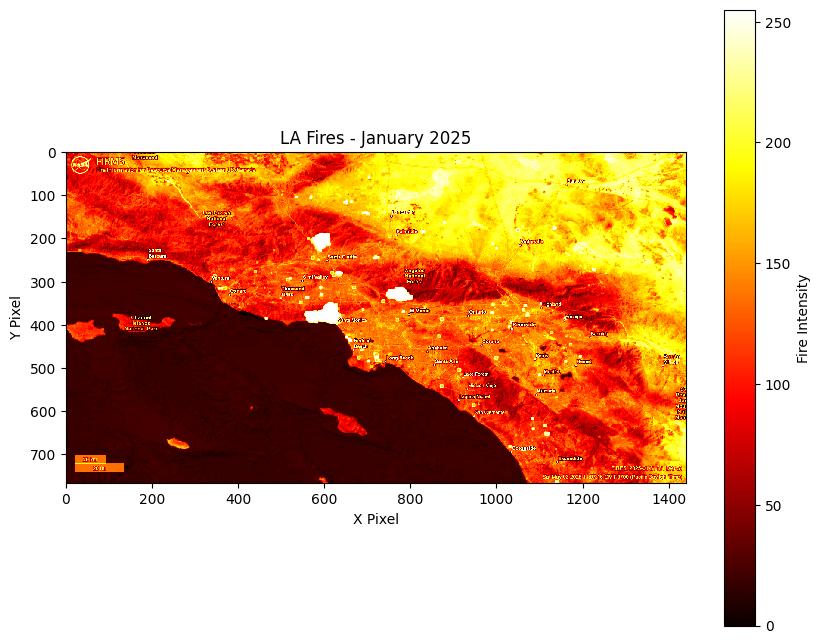

In [ ]:
# Display the Raster Data

## import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='hot', interpolation='none')
plt.colorbar(label='Fire Intensity')
plt.title('LA Fires - January 2025')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [ ]:
# Extract and Print Metadata

print("Raster metadata:")
print(f"Width: {profile['width']}")
print(f"Height: {profile['height']}")
print(f"CRS: {profile['crs']}")
print(f"Bounds: {bounds}")

Raster metadata:
Width: 1440
Height: 768
CRS: EPSG:4326
Bounds: BoundingBox(left=-120.2208830625, bottom=32.9975505, right=-116.2658049375, top=35.1069255)


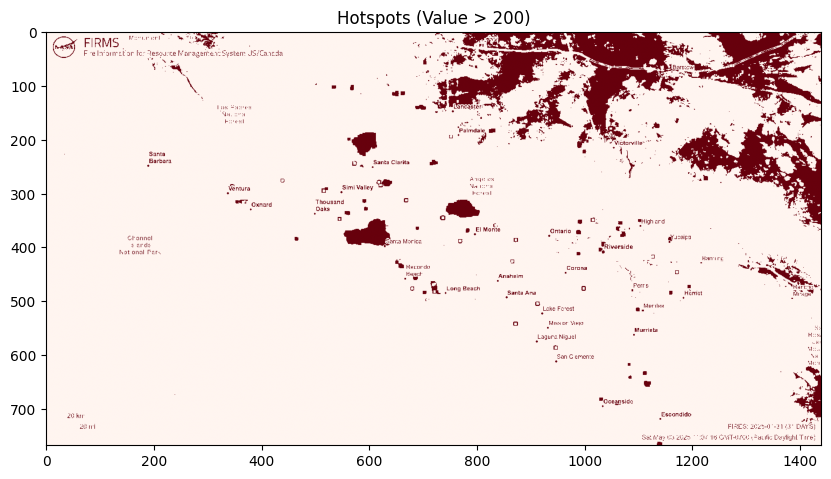

In [ ]:
# Analyze Burn Intensity or Hotspots

## Example: Highlight values greater than 200
threshold = 200
hotspots = np.where(raster > threshold, 1, 0)

plt.figure(figsize=(10, 8))
plt.imshow(hotspots, cmap='Reds')
plt.title(f'Hotspots (Value > {threshold})')
plt.show()

In [ ]:
# Extract Lat/Lon of Hotspots

import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import xy

# Open raster file
raster_path = '/content/sample_data/Raster.tif'
threshold = 200  # Set your intensity threshold

with rasterio.open(raster_path) as src:
    raster = src.read(1)  # First band
    transform = src.transform

    # Get row, col indices of pixels above threshold
    rows, cols = np.where(raster > threshold)

    # Convert pixel indices to lat/lon
    lons, lats = zip(*[xy(transform, r, c) for r, c in zip(rows, cols)])

# Create DataFrame of hotspot coordinates
hotspot_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'value': raster[rows, cols]
})

# Show a few rows
hotspot_df


,latitude,longitude,value
0,35.105552,-119.769070,221
1,35.105552,-119.763577,209
2,35.105552,-119.752591,206
3,35.105552,-119.749844,221
4,35.105552,-119.744351,222
...,...,...,...
94839,32.998924,-117.088406,234
94840,32.998924,-117.085660,226
94841,32.998924,-117.082913,228
94842,32.998924,-117.080167,225


Vector Dataset

In [ ]:
!pip install geopandas pyproj


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load CSV
df = pd.read_csv('/content/sample_data/Vector.csv')

# Create geometry from X, Y
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Check coordinate range
print(f"X range: {df['X'].min()} to {df['X'].max()}")
print(f"Y range: {df['Y'].min()} to {df['Y'].max()}")


X range: -13153911.2339 to -13137740.9218
Y range: 4050437.6546 to 4060019.4567


In [ ]:
# Assign original CRS (e.g., EPSG:32611 if UTM Zone 11N)
gdf.set_crs(epsg=32611, inplace=True)  # Update if you know the correct CRS

# Convert to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Show first few converted coordinates
print(gdf[['geometry']].head())


                    geometry
0  POINT (164.13842 7.69886)
1    POINT (164.13369 7.699)
2  POINT (164.13364 7.69898)
3  POINT (164.13839 7.69883)
4  POINT (164.13842 7.69888)


In [ ]:
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y

filter = gdf[['OBJECTID','longitude', 'latitude', 'DAMAGE', 'STRUCTURETYPE']]


In [ ]:
filter

,OBJECTID,longitude,latitude,DAMAGE,STRUCTURETYPE
0,1,164.138422,7.698857,No Damage,Single Family Residence Multi Story
1,2,164.133688,7.699003,No Damage,Single Family Residence Multi Story
2,3,164.133641,7.698981,Affected (1-9%),Single Family Residence Single Story
3,4,164.138387,7.698832,No Damage,Utility Misc Structure
4,5,164.138416,7.698882,No Damage,Single Family Residence Single Story
...,...,...,...,...,...
18421,18621,164.123673,7.694376,Destroyed (>50%),Utility Misc Structure
18422,18622,164.126659,7.694708,Destroyed (>50%),Utility Misc Structure
18423,18623,164.126578,7.700621,Destroyed (>50%),Utility Misc Structure
18424,18624,164.146072,7.704057,Destroyed (>50%),Utility Misc Structure


In [ ]:
filter.groupby('DAMAGE').size()

,0
DAMAGE,
Affected (1-9%),857
Destroyed (>50%),9418
Inaccessible,40
Major (26-50%),70
Minor (10-25%),148
No Damage,7893


In [ ]:
filter.groupby('STRUCTURETYPE').size()

,0
STRUCTURETYPE,
Church,21
Commercial Building Multi Story,54
Commercial Building Single Story,216
Hospital,2
Infrastructure,102
Mixed Commercial/Residential,13
Mobile Home Double Wide,4
Mobile Home Single Wide,6
Motor Home,10


In [119]:
# Group by STRUCTURETYPE and DAMAGE, then sort by count descending
grouped = (
    filter.groupby(['STRUCTURETYPE', 'DAMAGE'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# Show the top of the sorted table
print(grouped.head())


                           STRUCTURETYPE            DAMAGE  count
48  Single Family Residence Single Story  Destroyed (>50%)   5160
52  Single Family Residence Single Story         No Damage   3672
54                Utility Misc Structure  Destroyed (>50%)   3137
58                Utility Misc Structure         No Damage   2299
46   Single Family Residence Multi Story         No Damage   1410


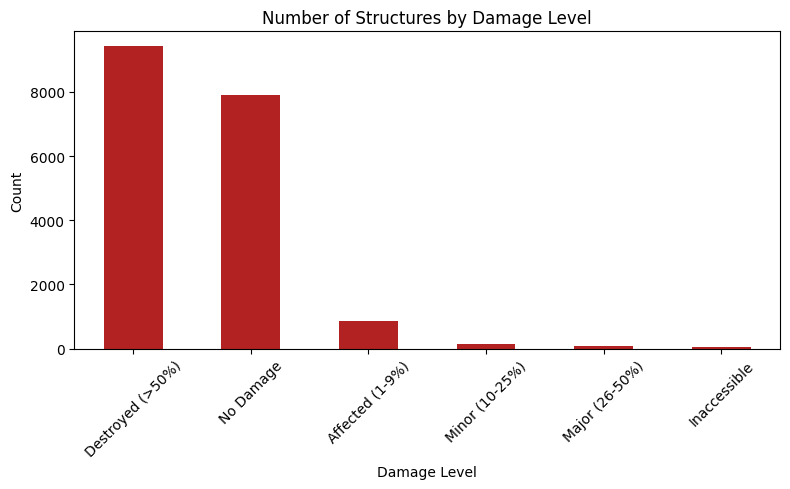

In [ ]:
import matplotlib.pyplot as plt

filter['DAMAGE'].value_counts().plot(kind='bar', color='firebrick', figsize=(8, 5))
plt.title('Number of Structures by Damage Level')
plt.xlabel('Damage Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-121-24d0feb34bb9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter['geometry'] = [Point(xy) for xy in zip(filter['longitude'], filter['latitude'])]


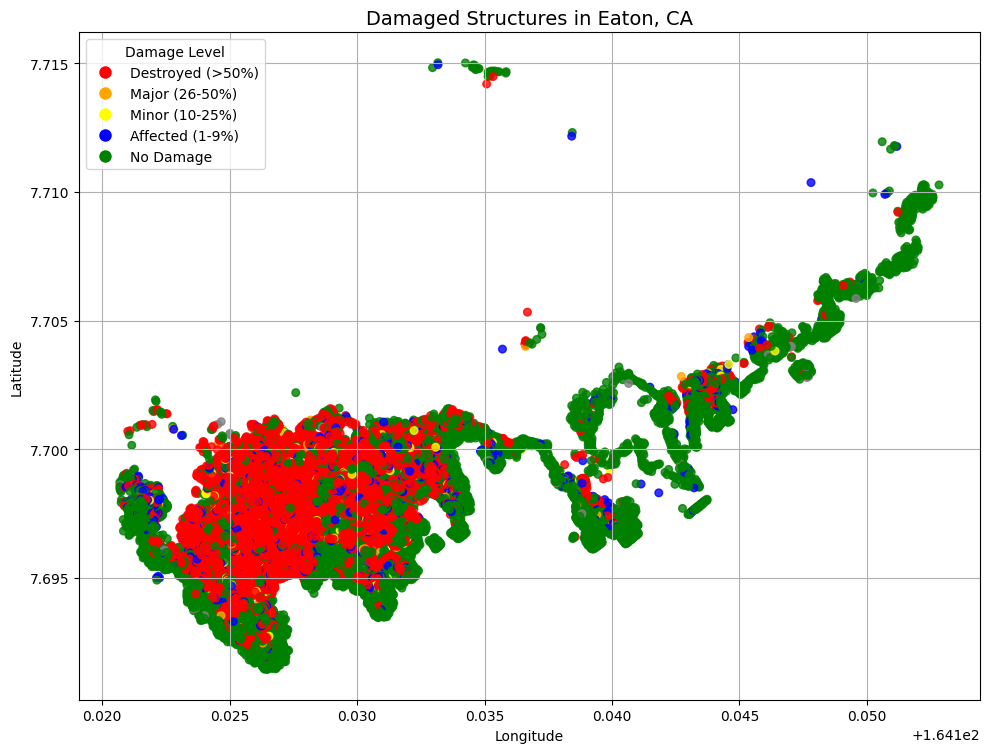

In [121]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your `filter` GeoDataFrame already contains geometry and WGS84 CRS
# If not, create geometry again just to be safe
from shapely.geometry import Point
filter['geometry'] = [Point(xy) for xy in zip(filter['longitude'], filter['latitude'])]
gdf = gpd.GeoDataFrame(filter, geometry=filter['geometry'], crs='EPSG:4326')

# Optional: Define colors for each damage level
damage_colors = {
    'Destroyed (>50%)': 'red',
    'Major (26-50%)': 'orange',
    'Minor (10-25%)': 'yellow',
    'Affected (1-9%)': 'blue',
    'No Damage': 'green'
}
gdf['color'] = gdf['DAMAGE'].map(damage_colors).fillna('gray')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], markersize=30, alpha=0.8)

# Add title and legend
plt.title('Damaged Structures in Eaton, CA', fontsize=14)
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                            markerfacecolor=value, markersize=10)
                 for key, value in damage_colors.items()]
plt.legend(handles=legend_labels, title='Damage Level')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()
